In [1]:
import sys
sys.path.append("../../src")
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import pickle
from example_pendulum import get_pendulum_data, pendulum_to_movie
from scipy.integrate import odeint
from autoencoder_pendulum_masked import full_network
from training_pendulum import create_feed_dictionary
from sindy_utils import sindy_simulate_order2
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/marsgao/.conda/envs/mars/lib/python3.7/site-packages

In [2]:
data_path = os.getcwd() + '/'
save_name = 'model7'
params = pickle.load(open(data_path + save_name + '_params.pkl', 'rb'))
params['save_name'] = data_path + save_name

autoencoder_network = full_network(params)
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))

tensorflow_run_tuple = ()
for key in autoencoder_network.keys():
    tensorflow_run_tuple += (autoencoder_network[key],)

## Single trajectory plots

In [28]:
arr = np.load("save_18.npy")
arr_truncate = arr[0:-420]
arr_truncate[0]

array([[-8.81898595e-05],
       [ 2.87306375e-05],
       [-3.14143658e-01],
       [-4.98609185e-01],
       [ 5.57949170e-02],
       [-2.26756632e-01],
       [ 9.62953717e-02],
       [-1.67004000e-02],
       [ 9.22765685e-05],
       [ 1.10809727e+01],
       [ 1.34908201e-04]])

In [29]:
arr_mean = np.mean(arr_truncate, axis=0)
arr_std = np.std(arr_truncate, axis=0)

In [30]:
arr_mean

array([[-4.10059511e-06],
       [-9.64962765e-07],
       [-3.13796918e-01],
       [-8.71701795e-02],
       [ 1.57231896e-02],
       [-3.03003504e-02],
       [ 2.11434682e-02],
       [-7.17190859e-03],
       [ 6.55107852e-06],
       [ 1.11552560e+01],
       [ 4.13028192e-06]])

In [31]:
arr_mean + 2*arr_std

array([[ 2.57867381e-04],
       [ 2.42112400e-04],
       [-3.13242410e-01],
       [ 2.11800597e-01],
       [ 5.49433134e-02],
       [ 9.38942957e-02],
       [ 8.43661950e-02],
       [ 5.06151138e-03],
       [ 4.56539472e-05],
       [ 1.12699505e+01],
       [ 2.66792795e-04]])

In [32]:
arr_mean - 2*arr_std

array([[-2.66068571e-04],
       [-2.44042326e-04],
       [-3.14351425e-01],
       [-3.86140956e-01],
       [-2.34969341e-02],
       [-1.54494996e-01],
       [-4.20792586e-02],
       [-1.94053286e-02],
       [-3.25517902e-05],
       [ 1.10405616e+01],
       [-2.58532231e-04]])

In [34]:
arr = np.load("save_refinement_18.npy")
arr_truncate = arr[0:-420]
arr_mean = np.mean(arr_truncate, axis=0)
arr_std = np.std(arr_truncate, axis=0)
arr_mean

array([[ 2.08726740e-03],
       [-1.92043297e-03],
       [ 1.58426167e-03],
       [-2.70040201e-04],
       [ 2.45522717e-03],
       [-2.45277886e-03],
       [ 5.61188398e-04],
       [ 1.39499276e-04],
       [ 1.15108839e-03],
       [ 1.04144794e+01],
       [-3.39831359e-03]])

In [35]:
arr_mean + 2*arr_std

array([[ 0.02848427],
       [ 0.02759847],
       [ 0.02754363],
       [ 0.0255383 ],
       [ 0.02865408],
       [ 0.02078561],
       [ 0.02709594],
       [ 0.02531203],
       [ 0.03092284],
       [12.50854909],
       [ 0.02406072]])

In [36]:
arr_mean - 2*arr_std

array([[-0.02430974],
       [-0.03143933],
       [-0.02437511],
       [-0.02607838],
       [-0.02374363],
       [-0.02569117],
       [-0.02597356],
       [-0.02503303],
       [-0.02862067],
       [ 8.32040971],
       [-0.03085735]])

-0.0033983135894595762 0.01372951635831917
10.414479398727417 1.0470348459908283
0.0011510883938899497 0.014885878014017796
0.00013949927612884493 0.012586267076042292
0.0005611883982783183 0.013267375198620035
-0.0024527788601699284 0.011619193087916221
0.002455227172176819 0.013099428228460733
-0.00027004020055755975 0.01290416765270124
0.0015842616667214315 0.012979684707984478
-0.001920432970073307 0.014759450284066049
0.0020872674041311256 0.013198501861971359


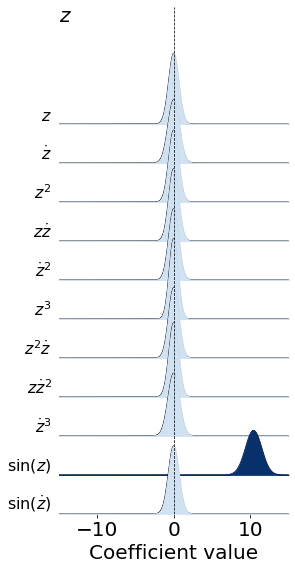

In [48]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

library_names = [r"$z$", r"$\dot{z}$", r"$z^2$", r"$z\dot{z}$", r"$\dot{z}^2$",
                r"$z^3$",r"$z^2\dot{z}$",r"$z\dot{z}^2$",r"$\dot{z}^3$",r"$\sin(z)$",r"$\sin(\dot{z})$",]
library_names.reverse()
def curve(arr):
    n = 1
    center = np.mean(arr)
    scale = np.std(arr)
    print(center, scale)
    if scale <= 0.2:
        scale *= 50.0
    X = np.zeros(500)
    x = np.linspace(-15, 15, len(X))
    X = 1.0/(scale*np.sqrt(2*np.pi)) * np.exp(-0.5 * ((x - center) / scale)**2)
    return X

cmap = mpl.cm.get_cmap("Blues")
fig = plt.figure(figsize=(8, 8))
arr_truncate = arr_truncate.reshape((100, 11))

ax = None
for n in range(1):
    ax = plt.subplot(1, 2, n + 1, frameon=False, sharex=ax)
    for i in range(len(arr_mean)):
        Y = curve(arr_truncate[:,10-i])
#         hist, bin_edges = np.histogram(arr_truncate[:,i], density=True)
#         Y = hist/len(arr_truncate[:,i])
        X = np.linspace(-15, 15, len(Y))
        ax.plot(X, 3 * Y + i, color="k", linewidth=0.75, zorder=100 - i)
        color = cmap(abs(arr_mean[10-i]) / 3.0 + 0.2)
        ax.fill_between(X, 3 * Y + i, i, color=color, zorder=100 - i)

    ax.yaxis.set_tick_params(tick1On=False)
    ax.set_xlim(-15, 15)
    ax.set_ylim(3, 13)
    ax.axvline(0.0, ls="--", lw=0.75, color="black", zorder=250)
    ax.text(
        0.0,
        1.0,
        r"$z$",
        ha="left",
        va="top",
        weight="bold",
        transform=ax.transAxes,
    )

    if n == 0:
        ax.yaxis.set_tick_params(labelleft=True)
        ax.set_yticks(np.arange(len(arr_mean)))
#         ax.set_yticklabels(["Serie %d" % i for i in range(1, len(arr_mean)+1)])
        ax.set_yticklabels(library_names)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(16)
            tick.label.set_verticalalignment("bottom")
    else:
        ax.yaxis.set_tick_params(labelleft=False)

plt.rcParams.update({'font.size': 20})
# cax = plt.axes([0.85, 0.1, 0.075, 0.8])
# plt.colorbar(fig, cax=cax)
plt.tight_layout()
plt.xlabel('Coefficient value')
plt.show()

In [53]:
t = np.arange(0, 100, .02)
z0s = np.pi/np.array([1.5,2,3,4,8,16])
dz0s = .5*np.ones(z0s.shape)

f  = lambda z, t : [z[1], -np.sin(z[0])]
n_ics = z0s.size

z = np.zeros((n_ics,t.size,2))
dz = np.zeros(z.shape)
for i in range(n_ics):
    z[i] = odeint(f, [z0s[i],dz0s[i]], t)
    dz[i] = np.array([f(z[i,j], t[j]) for j in range(len(t))])
    
x = np.load("decode_x.npy")
dx = np.load("dx_decode.npy")
ddx = np.load("ddx_decode.npy")

In [54]:
test_data = {}
test_data['x'] = x.reshape((-1,params['input_dim']))
test_data['dx'] = dx.reshape((-1,params['input_dim']))
test_data['ddx'] = ddx.reshape((-1,params['input_dim']))
# test_data['z'] = z[:,:,0].reshape((-1,params['latent_dim']))
# test_data['dz'] = z[:,:,1].reshape((-1,params['latent_dim']))
# test_data['ddz'] = dz[:,:,1].reshape((-1,params['latent_dim']))

### 

In [55]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/marsgao/SindyAutoencoders/examples/pen_video/model7


2022-08-28 13:32:02.390541: I tensorflow/stream_executor/platform/default/dso_loader.cc:42] Successfully opened dynamic library libcuda.so.1
2022-08-28 13:32:02.448299: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-28 13:32:02.448366: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: lambda
2022-08-28 13:32:02.448377: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: lambda
2022-08-28 13:32:02.448544: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-08-28 13:32:02.448585: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-08-28 13:32:02.448594: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1
2022-08-28 13:32:02.449614: I tensorflow/core/platform/cpu_feature_gua

ValueError: Cannot feed value of shape () for Tensor 'random_mask:0', which has shape '(?, 648)'

In [154]:
true_coefficients = np.zeros(test_set_results['sindy_coefficients'].shape)
true_coefficients[-2] = -1.

z_sim = np.zeros((n_ics, t.size, 2))
pendulum_sim = np.zeros(z_sim.shape)
mc_num = 10
mc_z_sim = np.zeros((mc_num, n_ics, t.size, 2))
for i in range(n_ics):
    z_sim[i] = sindy_simulate_order2(test_set_results['z'][i*t.size], test_set_results['dz'][i*t.size], t,
                                     params['coefficient_mask']*test_set_results['sindy_coefficients'],
                                     params['poly_order'], params['include_sine'])
    for j in range(mc_num):
#         mc_z_sim[j,i] = sindy_simulate_order2(test_set_results['z'][i*t.size], test_set_results['dz'][i*t.size], t,
#                                      (params['coefficient_mask'].T*arr_truncate[j*8]).T,
#                                      params['poly_order'], params['include_sine'])
        coeff = arr_truncate[j*8].reshape(12, 1)
        mc_z_sim[j,i] = sindy_simulate_order2(test_set_results['z'][i*t.size], test_set_results['dz'][i*t.size], t,
                                     params['coefficient_mask']*coeff,
                                     params['poly_order'], params['include_sine'])
    pendulum_sim[i] = sindy_simulate_order2(test_data['z'][i*t.size], test_data['dz'][i*t.size], t,
                                            true_coefficients,
                                            params['poly_order'], params['include_sine'])

In [155]:
arr_truncate[0]

array([-0.00371719, -0.03170317, -0.04620611,  0.03559589, -0.01867101,
       -0.03888724,  0.02106883,  0.05354684,  0.00639916,  0.00312219,
       -1.12888968,  0.03559225])

In [156]:
mc_z_sim.shape

(10, 6, 5000, 2)

([], [])

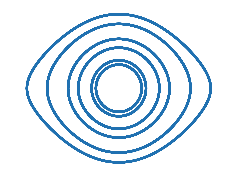

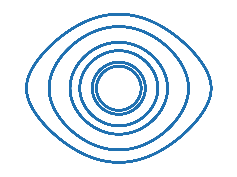

In [157]:
plt.figure(figsize=(4,3))
plt.plot(z_sim[:,:,0].T, z_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(4,3))
plt.plot(pendulum_sim[:,:,0].T, pendulum_sim[:,:,1].T, linewidth=2, color='#2071B1')
plt.axis('equal')
plt.axis('off')
plt.xticks([])
plt.yticks([])

(-249.95000000000002, 5248.95, -2.1052295078905, 2.1314066540157586)

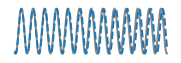

In [158]:
ic_idx = 1

plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)
plt.plot(z_sim[ic_idx,:,0], '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

(-249.95000000000002, 5248.95, -2.10651012514814, 2.131467635789932)

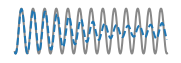

In [159]:
ic_idx = 1

plt.figure(figsize=(3,2))
plt.subplot(2,1,1)
plt.plot(test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)
# plt.plot(z_sim[ic_idx,:,0], '--', linewidth=2)
plt.plot(np.mean(mc_z_sim[:, ic_idx,:,0], axis=0), '--', linewidth=2)
plt.xticks([])
plt.yticks([])
plt.axis('off')

Text(0.5, 0, 'Time')

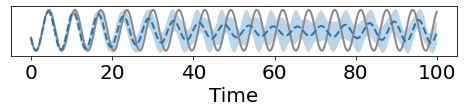

In [239]:
ic_idx = 5

plt.figure(figsize=(8,2))
plt.subplot(2,1,1)
plt.plot(t, test_set_results['z'][ic_idx*t.size:(ic_idx+1)*t.size,0], 'k', color='#888888', linewidth=2)
# plt.plot(z_sim[ic_idx,:,0], '--', linewidth=2)
plt.plot(t, np.mean(mc_z_sim[:, ic_idx,:,0], axis=0), '--', linewidth=2)
plt.fill_between(t, np.mean(mc_z_sim[:, ic_idx,:,0], axis=0)-np.std(mc_z_sim[:, ic_idx,:,0], axis=0),
                np.mean(mc_z_sim[:, ic_idx,:,0], axis=0)+np.std(mc_z_sim[:, ic_idx,:,0], axis=0), alpha=0.3)
plt.xticks([0, 20, 40, 60, 80, 100])
# plt.xticks([])
plt.yticks([])
plt.xlabel('Time')
# plt.figure(figsize=(100,2))
# plt.axes([0, 0.6, 1, 1])
# plt.axis('off')

In [11]:
test_data = get_pendulum_data(10)

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, data_path + save_name)
    test_dictionary = create_feed_dictionary(test_data, params)
    tf_results = sess.run(tensorflow_run_tuple, feed_dict=test_dictionary)

test_set_results = {}
for i,key in enumerate(autoencoder_network.keys()):
    test_set_results[key] = tf_results[i]

INFO:tensorflow:Restoring parameters from /home/marsgao/BayesianSindyAutoencoder/exmaples/pendulum/model16


In [50]:
decoder_x_error = np.mean((test_data['x'] - test_set_results['x_decode'])**2)/np.mean(test_data['x']**2)
decoder_ddx_error = np.mean((test_data['ddx'] - test_set_results['ddx_decode'])**2)/np.mean(test_data['ddx']**2)
sindy_ddz_error = np.mean((test_set_results['ddz'] - test_set_results['ddz_predict'])**2)/np.mean(test_set_results['ddz']**2)

print('Decoder relative error: %f' % decoder_x_error)
print('Decoder relative SINDy error: %f' % decoder_ddx_error)
print('SINDy reltive error, z: %f' % sindy_ddz_error)

NameError: name 'test_data' is not defined